In [1]:
import time
start = time.time()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import itertools
import statsmodels.api as sm
import matplotlib
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
# Data 
df = pd.read_csv('agg_data.csv')
df.drop(['Unnamed: 0','Unnamed: 0.1'],inplace = True, axis = 1)
df['StayDate'] = pd.to_datetime(df['StayDate'])
df = df[df['Property'] == 'RRI133'][['StayDate','no_of_bookings']]
df['year'] = pd.DatetimeIndex(df['StayDate']).year
df['week_number'] = df['StayDate'].dt.isocalendar().week
df['week_day'] = pd.DatetimeIndex(df['StayDate']).weekday
df.set_index('StayDate', inplace = True)
df.sort_index(inplace=True)
df.tail(5)

,no_of_bookings,year,week_number,week_day
StayDate,,,,
2021-08-24,59,2021,34,1
2021-08-25,42,2021,34,2
2021-08-26,16,2021,34,3
2021-08-27,3,2021,34,4
2021-08-28,2,2021,34,5


In [4]:
t = 36

for i in range(1,t):
    col = 't - {}'.format(i)
    df[col] = df['no_of_bookings'].shift(i)


In [5]:
#First Year
for i in range(363,368):
    col = 't - {}'.format(i)
    df[col] = df['no_of_bookings'].shift(i)


In [6]:
#Second Year
#First Year
for i in range(727,732):
    col = 't - {}'.format(i)
    df[col] = df['no_of_bookings'].shift(i)

In [7]:
#Third Year
#First Year
for i in range(1091,1095):
    col = 't - {}'.format(i)
    df[col] = df['no_of_bookings'].shift(i)

In [8]:
df = df.dropna()
df['week_number'] = df['week_number'].astype('int')
df.iloc[:,4:] = df.iloc[:,4:] .astype('int')

In [9]:
import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2015,2016,2017,2018,2019,2020,2021]).items()):
    holiday = holiday.append(pd.DataFrame({'StayDate': date, 'holiday': 1}, index=[0]), ignore_index=True)
holiday['StayDate'] = pd.to_datetime(holiday['StayDate'], format='%Y-%m-%d', errors='ignore')
holiday.set_index('StayDate', inplace = True)
holiday.sort_index(inplace=True)
df = pd.merge(df, holiday, how="left",left_index=True, right_index=True)
df['holiday'].fillna(value = 0,inplace = True)
df.loc[(df.week_day == 5) | (df.week_day == 6), 'holiday'] = 1
df['holiday'] = df['holiday'].astype('int') 
df = df[:'2021-08-15']

In [10]:
df.tail(5)

,no_of_bookings,year,week_number,week_day,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12,t - 13,t - 14,t - 15,t - 16,t - 17,t - 18,t - 19,t - 20,t - 21,t - 22,t - 23,t - 24,t - 25,t - 26,t - 27,t - 28,t - 29,t - 30,t - 31,t - 32,t - 33,t - 34,t - 35,t - 363,t - 364,t - 365,t - 366,t - 367,t - 727,t - 728,t - 729,t - 730,t - 731,t - 1091,t - 1092,t - 1093,t - 1094,holiday
StayDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-11,68,2021,32,2,54,52,61,79,67,54,62,60,51,57,74,69,67,65,67,68,71,71,66,60,72,68,66,73,80,66,52,53,62,65,64,73,70,69,63,59,73,74,71,77,61,55,53,65,62,57,57,49,47,0
2021-08-12,67,2021,32,3,68,54,52,61,79,67,54,62,60,51,57,74,69,67,65,67,68,71,71,66,60,72,68,66,73,80,66,52,53,62,65,64,73,70,69,65,59,73,74,71,68,61,55,53,65,59,57,57,49,0
2021-08-13,70,2021,32,4,67,68,54,52,61,79,67,54,62,60,51,57,74,69,67,65,67,68,71,71,66,60,72,68,66,73,80,66,52,53,62,65,64,73,70,81,65,59,73,74,57,68,61,55,53,51,59,57,57,0
2021-08-14,88,2021,32,5,70,67,68,54,52,61,79,67,54,62,60,51,57,74,69,67,65,67,68,71,71,66,60,72,68,66,73,80,66,52,53,62,65,64,73,78,81,65,59,73,58,57,68,61,55,36,51,59,57,1
2021-08-15,71,2021,32,6,88,70,67,68,54,52,61,79,67,54,62,60,51,57,74,69,67,65,67,68,71,71,66,60,72,68,66,73,80,66,52,53,62,65,64,72,78,81,65,59,46,58,57,68,61,48,36,51,59,1


In [11]:
df['long_weekend'] = 0
for i in range(0,df.shape[0]):
    if (df.iloc[i,-2] == 1) and (df.iloc[i,3] == 4):
        df.iloc[i:i+3,-1] = 1
    elif (df.iloc[i,-2] == 1) and (df.iloc[i,3] == 0):
        df.iloc[i-2:i+1,-1] = 1

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,2)
    return mape 

# Gradient Boosting

In [13]:
X_train = df['2018-01-01': '2021-06-30'].drop('no_of_bookings',axis = 1)
X_test = df.loc['2021-07-01':, :].drop('no_of_bookings',axis = 1)
y_train = df.loc['2018-01-01': '2021-06-30','no_of_bookings']
y_test = df.loc['2021-07-01':,'no_of_bookings']

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [15]:
### Lets Do the prediction and check performance metrics
train_predict = reg.predict(X_train)
test_predict = reg.predict(X_test)

In [16]:
### Test Data RMSE
import math
math.sqrt(mean_squared_error(y_test,test_predict))

6.574610790404327

In [17]:
fitted_values = df.loc['2018-01-01':'2021-06-30','no_of_bookings': 'week_day'].copy()
fitted_values['gb_fitted_values'] = train_predict
forecasted_values = df.loc['2021-07-01':'2021-08-15','no_of_bookings': 'week_day'].copy()
forecasted_values['gb_values'] = test_predict

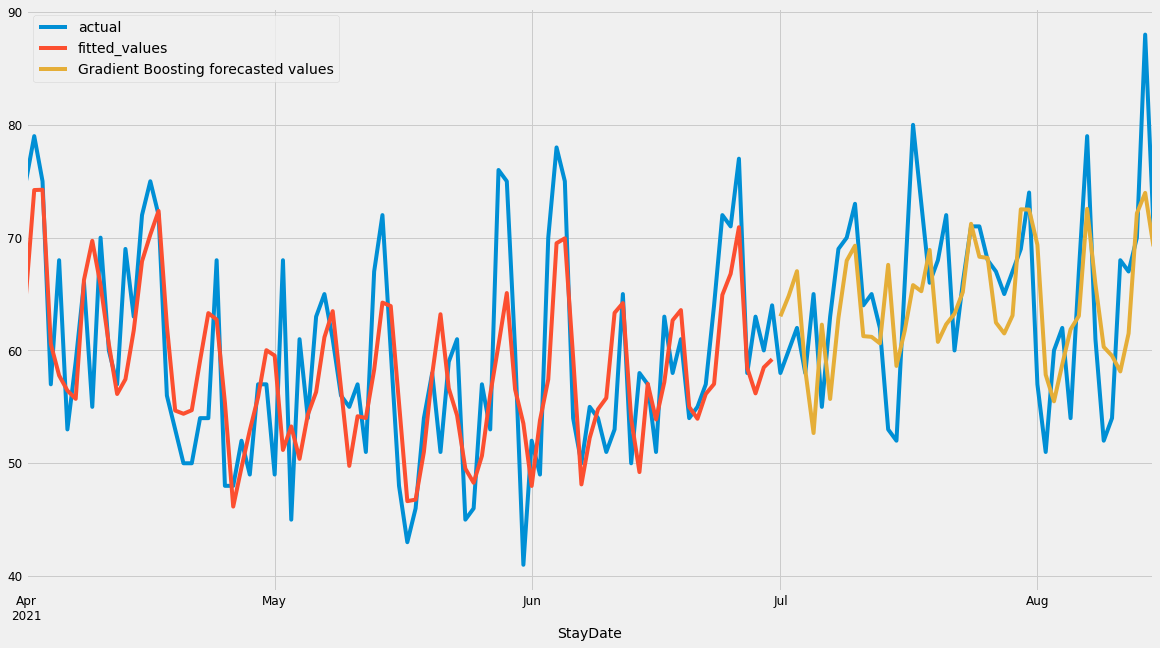

In [18]:
plt.figure(figsize = (18,10))
df.loc['2021-04-01':,'no_of_bookings'].plot(label = 'actual')
fitted_values.loc['2021-04-01':,'gb_fitted_values'].plot(label = 'fitted_values')
forecasted_values.loc[:,'gb_values'].plot(label = 'Gradient Boosting forecasted values')
plt.legend()
plt.show()

In [19]:
print('Gradient Boosting Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['gb_values']))))

Gradient Boosting Mape : 8.54


# Tuning GB parameters

In [20]:
# Tuning GB
import sklearn
from sklearn.model_selection import GridSearchCV
p_test3 = {'learning_rate':[0.25,0.2,0.15,0.1,0.05], 'n_estimators':[10,25,50,100,250]}

tuning = GridSearchCV(estimator =GradientBoostingRegressor(criterion = 'mae'), 
            param_grid = p_test3,n_jobs=4)
tuning.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1630: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


GridSearchCV(estimator=GradientBoostingRegressor(criterion='mae'), n_jobs=4,
             param_grid={'learning_rate': [0.25, 0.2, 0.15, 0.1, 0.05],
                         'n_estimators': [10, 25, 50, 100, 250]})

In [21]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15, 'n_estimators': 50}, 0.4203040260662216)

In [22]:
test_predict = tuning.predict(X_test)

In [23]:
### Lets Do the prediction and check performance metrics
train_predict = tuning.predict(X_train)
test_predict = tuning.predict(X_test)

In [24]:
fitted_values['tuned_gb_fitted_values'] = train_predict
forecasted_values['tuned_gb_values'] = test_predict

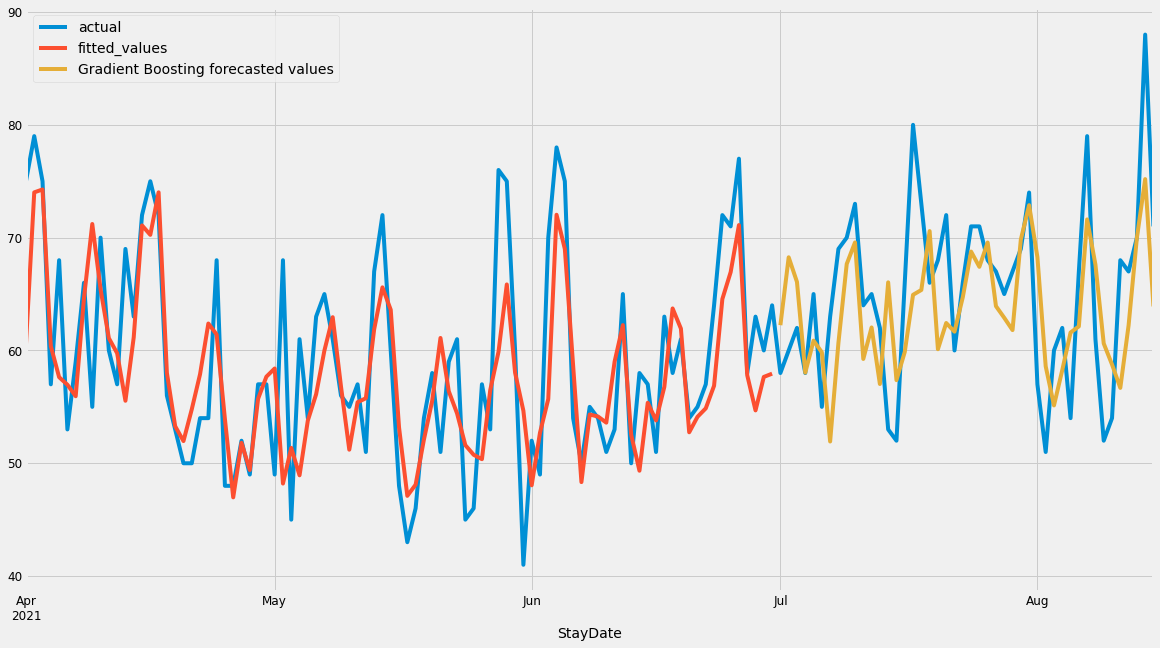

In [25]:
plt.figure(figsize = (18,10))
df.loc['2021-04-01':,'no_of_bookings'].plot(label = 'actual')
fitted_values.loc['2021-04-01':,'tuned_gb_fitted_values'].plot(label = 'fitted_values')
forecasted_values.loc[:,'tuned_gb_values'].plot(label = 'Gradient Boosting forecasted values')
plt.legend()
plt.show()

In [26]:
print('Tuned Gradient Boosting Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(test_predict))))

Tuned Gradient Boosting Mape : 8.77


# Data

In [27]:
X_train = np.array(df['2018-01-01': '2021-06-30'].drop('no_of_bookings',axis = 1))
X_test = np.array(df.loc['2021-07-01':, :].drop('no_of_bookings',axis = 1))
y_train = np.array(df.loc['2018-01-01': '2021-06-30','no_of_bookings'])
y_test = np.array(df.loc['2021-07-01':,'no_of_bookings'])

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1277, 54, 1), (1277,), (46, 54, 1), (46,))

# LSTM Model 

In [28]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [29]:
lstm=Sequential()
lstm.add(LSTM(50,return_sequences=True,input_shape=(34,1)))
lstm.add(LSTM(25,return_sequences=True))
lstm.add(LSTM(25,return_sequences=True))
lstm.add(LSTM(15,return_sequences=True))
lstm.add(LSTM(10))
lstm.add(Dense(5))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',optimizer='adam')

In [30]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 34, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 34, 25)            7600      
_________________________________________________________________
lstm_2 (LSTM)                (None, 34, 25)            5100      
_________________________________________________________________
lstm_3 (LSTM)                (None, 34, 15)            2460      
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                1040      
_________________________________________________________________
dense (Dense)                (None, 5)                 55        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [31]:
lstm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1500,batch_size=64,verbose=1)

Epoch 1/1500
20/20 [==============================] - 7s 118ms/step - loss: 3044.6941 - val_loss: 4039.8152
Epoch 2/1500
20/20 [==============================] - 1s 61ms/step - loss: 2841.8911 - val_loss: 3807.9312
Epoch 3/1500
20/20 [==============================] - 1s 61ms/step - loss: 2652.7336 - val_loss: 3583.1296
Epoch 4/1500
20/20 [==============================] - 1s 60ms/step - loss: 2468.9678 - val_loss: 3364.9702
Epoch 5/1500
20/20 [==============================] - 1s 60ms/step - loss: 2298.4663 - val_loss: 3169.4895
Epoch 6/1500
20/20 [==============================] - 1s 60ms/step - loss: 2147.2258 - val_loss: 2995.1838
Epoch 7/1500
20/20 [==============================] - 1s 60ms/step - loss: 2011.2338 - val_loss: 2831.1499
Epoch 8/1500
20/20 [==============================] - 1s 61ms/step - loss: 1880.0897 - val_loss: 2665.4897
Epoch 9/1500
20/20 [==============================] - 1s 61ms/step - loss: 1743.7976 - val_loss: 2490.4368
Epoch 10/1500
20/20 [===============

Epoch 69/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.6368 - val_loss: 167.5548
Epoch 70/1500
20/20 [==============================] - 1s 61ms/step - loss: 154.6802 - val_loss: 166.6579
Epoch 71/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.6449 - val_loss: 167.1940
Epoch 72/1500
20/20 [==============================] - 1s 61ms/step - loss: 154.6453 - val_loss: 167.4211
Epoch 73/1500
20/20 [==============================] - 1s 60ms/step - loss: 154.6434 - val_loss: 167.5305
Epoch 74/1500
20/20 [==============================] - 1s 60ms/step - loss: 154.6393 - val_loss: 167.3592
Epoch 75/1500
20/20 [==============================] - 1s 60ms/step - loss: 154.6471 - val_loss: 167.8697
Epoch 76/1500
20/20 [==============================] - 1s 60ms/step - loss: 154.6366 - val_loss: 167.4138
Epoch 77/1500
20/20 [==============================] - 1s 60ms/step - loss: 154.6808 - val_loss: 168.3617
Epoch 78/1500
20/20 [=========================

Epoch 146/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.6464 - val_loss: 167.2182
Epoch 147/1500
20/20 [==============================] - 1s 64ms/step - loss: 154.6687 - val_loss: 168.0775
Epoch 148/1500
20/20 [==============================] - 1s 61ms/step - loss: 154.6661 - val_loss: 166.7789
Epoch 149/1500
20/20 [==============================] - 1s 61ms/step - loss: 154.6774 - val_loss: 166.4006
Epoch 150/1500
20/20 [==============================] - 1s 60ms/step - loss: 154.6958 - val_loss: 167.8312
Epoch 151/1500
20/20 [==============================] - 1s 61ms/step - loss: 154.6483 - val_loss: 167.8671
Epoch 152/1500
20/20 [==============================] - 1s 60ms/step - loss: 154.6550 - val_loss: 168.0308
Epoch 153/1500
20/20 [==============================] - 1s 61ms/step - loss: 154.6422 - val_loss: 166.8341
Epoch 154/1500
20/20 [==============================] - 1s 60ms/step - loss: 154.6882 - val_loss: 165.5862
Epoch 155/1500
20/20 [===============

20/20 [==============================] - 1s 63ms/step - loss: 154.6342 - val_loss: 169.1505
Epoch 223/1500
20/20 [==============================] - 1s 62ms/step - loss: 147.9462 - val_loss: 166.3071
Epoch 224/1500
20/20 [==============================] - 1s 62ms/step - loss: 166.8198 - val_loss: 144.7777
Epoch 225/1500
20/20 [==============================] - 1s 62ms/step - loss: 155.5471 - val_loss: 157.5402
Epoch 226/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.6569 - val_loss: 169.3156
Epoch 227/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.7462 - val_loss: 171.6604
Epoch 228/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.6744 - val_loss: 163.2112
Epoch 229/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.7850 - val_loss: 164.7410
Epoch 230/1500
20/20 [==============================] - 1s 63ms/step - loss: 154.6118 - val_loss: 176.3690
Epoch 231/1500
20/20 [==============================

20/20 [==============================] - 1s 63ms/step - loss: 152.9896 - val_loss: 162.5599
Epoch 299/1500
20/20 [==============================] - 1s 63ms/step - loss: 154.7448 - val_loss: 130.8129
Epoch 300/1500
20/20 [==============================] - 1s 71ms/step - loss: 158.6204 - val_loss: 165.0607
Epoch 301/1500
20/20 [==============================] - 1s 70ms/step - loss: 154.8354 - val_loss: 168.7717
Epoch 302/1500
20/20 [==============================] - 1s 63ms/step - loss: 154.6827 - val_loss: 164.0828
Epoch 303/1500
20/20 [==============================] - 1s 63ms/step - loss: 154.8747 - val_loss: 166.1331
Epoch 304/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.8832 - val_loss: 168.8682
Epoch 305/1500
20/20 [==============================] - 1s 61ms/step - loss: 155.2639 - val_loss: 170.4491
Epoch 306/1500
20/20 [==============================] - 1s 62ms/step - loss: 154.2072 - val_loss: 168.1389
Epoch 307/1500
20/20 [==============================

20/20 [==============================] - 1s 58ms/step - loss: 77.9012 - val_loss: 54.5853
Epoch 376/1500
20/20 [==============================] - 1s 58ms/step - loss: 76.1080 - val_loss: 50.9046
Epoch 377/1500
20/20 [==============================] - 1s 59ms/step - loss: 74.7076 - val_loss: 48.5617
Epoch 378/1500
20/20 [==============================] - 1s 58ms/step - loss: 75.1554 - val_loss: 48.6114
Epoch 379/1500
20/20 [==============================] - 1s 59ms/step - loss: 74.4724 - val_loss: 51.8720
Epoch 380/1500
20/20 [==============================] - 1s 58ms/step - loss: 76.5151 - val_loss: 50.0900
Epoch 381/1500
20/20 [==============================] - 1s 59ms/step - loss: 77.0586 - val_loss: 60.1654
Epoch 382/1500
20/20 [==============================] - 1s 58ms/step - loss: 77.2302 - val_loss: 49.6674
Epoch 383/1500
20/20 [==============================] - 1s 58ms/step - loss: 74.2397 - val_loss: 49.7694
Epoch 384/1500
20/20 [==============================] - 1s 58ms/step -

20/20 [==============================] - 1s 58ms/step - loss: 67.1338 - val_loss: 53.0473
Epoch 454/1500
20/20 [==============================] - 1s 58ms/step - loss: 70.5442 - val_loss: 54.0598
Epoch 455/1500
20/20 [==============================] - 1s 58ms/step - loss: 70.9750 - val_loss: 68.4544
Epoch 456/1500
20/20 [==============================] - 1s 59ms/step - loss: 68.3508 - val_loss: 50.1886
Epoch 457/1500
20/20 [==============================] - 1s 58ms/step - loss: 67.8741 - val_loss: 56.0957
Epoch 458/1500
20/20 [==============================] - 1s 59ms/step - loss: 67.1376 - val_loss: 51.6356
Epoch 459/1500
20/20 [==============================] - 1s 57ms/step - loss: 67.7987 - val_loss: 63.6370
Epoch 460/1500
20/20 [==============================] - 1s 59ms/step - loss: 66.2113 - val_loss: 49.6525
Epoch 461/1500
20/20 [==============================] - 1s 59ms/step - loss: 66.7993 - val_loss: 51.5318
Epoch 462/1500
20/20 [==============================] - 1s 60ms/step -

Epoch 531/1500
20/20 [==============================] - 1s 58ms/step - loss: 62.6134 - val_loss: 50.3251
Epoch 532/1500
20/20 [==============================] - 1s 59ms/step - loss: 63.0509 - val_loss: 43.2753
Epoch 533/1500
20/20 [==============================] - 1s 58ms/step - loss: 62.3209 - val_loss: 49.3455
Epoch 534/1500
20/20 [==============================] - 1s 58ms/step - loss: 60.1995 - val_loss: 52.9701
Epoch 535/1500
20/20 [==============================] - 1s 57ms/step - loss: 61.0721 - val_loss: 45.1817
Epoch 536/1500
20/20 [==============================] - 1s 58ms/step - loss: 61.0274 - val_loss: 42.8850
Epoch 537/1500
20/20 [==============================] - 1s 58ms/step - loss: 63.5297 - val_loss: 43.6293
Epoch 538/1500
20/20 [==============================] - 1s 58ms/step - loss: 62.1756 - val_loss: 75.1143
Epoch 539/1500
20/20 [==============================] - 1s 57ms/step - loss: 63.3228 - val_loss: 40.2715
Epoch 540/1500
20/20 [==============================] -

20/20 [==============================] - 1s 59ms/step - loss: 55.7419 - val_loss: 44.5815
Epoch 610/1500
20/20 [==============================] - 1s 60ms/step - loss: 55.2840 - val_loss: 51.8028
Epoch 611/1500
20/20 [==============================] - 1s 58ms/step - loss: 56.7496 - val_loss: 45.3858
Epoch 612/1500
20/20 [==============================] - 1s 57ms/step - loss: 55.8733 - val_loss: 42.8822
Epoch 613/1500
20/20 [==============================] - 1s 57ms/step - loss: 54.4644 - val_loss: 43.4457
Epoch 614/1500
20/20 [==============================] - 1s 58ms/step - loss: 56.1257 - val_loss: 46.3941
Epoch 615/1500
20/20 [==============================] - 1s 57ms/step - loss: 57.1077 - val_loss: 44.6131
Epoch 616/1500
20/20 [==============================] - 1s 60ms/step - loss: 57.6882 - val_loss: 54.3835
Epoch 617/1500
20/20 [==============================] - 1s 59ms/step - loss: 55.2333 - val_loss: 50.6414
Epoch 618/1500
20/20 [==============================] - 1s 58ms/step -

Epoch 687/1500
20/20 [==============================] - 1s 58ms/step - loss: 52.5864 - val_loss: 40.5540
Epoch 688/1500
20/20 [==============================] - 1s 58ms/step - loss: 52.8587 - val_loss: 56.0461
Epoch 689/1500
20/20 [==============================] - 1s 58ms/step - loss: 52.0501 - val_loss: 51.2381
Epoch 690/1500
20/20 [==============================] - 1s 58ms/step - loss: 50.9935 - val_loss: 43.3560
Epoch 691/1500
20/20 [==============================] - 1s 58ms/step - loss: 49.7898 - val_loss: 44.9730
Epoch 692/1500
20/20 [==============================] - 1s 58ms/step - loss: 50.3223 - val_loss: 53.3826
Epoch 693/1500
20/20 [==============================] - 1s 58ms/step - loss: 50.2653 - val_loss: 40.8733
Epoch 694/1500
20/20 [==============================] - 1s 57ms/step - loss: 51.6305 - val_loss: 56.7235
Epoch 695/1500
20/20 [==============================] - 1s 58ms/step - loss: 51.5645 - val_loss: 49.3172
Epoch 696/1500
20/20 [==============================] -

20/20 [==============================] - 1s 58ms/step - loss: 46.6724 - val_loss: 49.5428
Epoch 766/1500
20/20 [==============================] - 1s 58ms/step - loss: 48.2061 - val_loss: 42.6645
Epoch 767/1500
20/20 [==============================] - 1s 58ms/step - loss: 47.5896 - val_loss: 47.1394
Epoch 768/1500
20/20 [==============================] - 1s 58ms/step - loss: 48.4418 - val_loss: 47.8645
Epoch 769/1500
20/20 [==============================] - 1s 58ms/step - loss: 46.1193 - val_loss: 50.0892
Epoch 770/1500
20/20 [==============================] - 1s 58ms/step - loss: 46.4075 - val_loss: 58.9864
Epoch 771/1500
20/20 [==============================] - 1s 59ms/step - loss: 45.5790 - val_loss: 54.1913
Epoch 772/1500
20/20 [==============================] - 1s 58ms/step - loss: 45.3521 - val_loss: 61.3544
Epoch 773/1500
20/20 [==============================] - 1s 58ms/step - loss: 44.7963 - val_loss: 52.3665
Epoch 774/1500
20/20 [==============================] - 1s 58ms/step -

20/20 [==============================] - 1s 58ms/step - loss: 41.8634 - val_loss: 52.8163
Epoch 844/1500
20/20 [==============================] - 1s 58ms/step - loss: 45.3062 - val_loss: 41.9827
Epoch 845/1500
20/20 [==============================] - 1s 58ms/step - loss: 43.5450 - val_loss: 50.1824
Epoch 846/1500
20/20 [==============================] - 1s 58ms/step - loss: 39.6078 - val_loss: 41.7435
Epoch 847/1500
20/20 [==============================] - 1s 58ms/step - loss: 39.8118 - val_loss: 39.5912
Epoch 848/1500
20/20 [==============================] - 1s 58ms/step - loss: 60.5195 - val_loss: 83.0479
Epoch 849/1500
20/20 [==============================] - 1s 58ms/step - loss: 60.3459 - val_loss: 58.8692
Epoch 850/1500
20/20 [==============================] - 1s 59ms/step - loss: 55.9626 - val_loss: 53.1145
Epoch 851/1500
20/20 [==============================] - 1s 59ms/step - loss: 52.4273 - val_loss: 46.5026
Epoch 852/1500
20/20 [==============================] - 1s 59ms/step -

Epoch 921/1500
20/20 [==============================] - 1s 61ms/step - loss: 39.4456 - val_loss: 45.6690
Epoch 922/1500
20/20 [==============================] - 1s 60ms/step - loss: 39.8137 - val_loss: 49.7402
Epoch 923/1500
20/20 [==============================] - 1s 60ms/step - loss: 37.8215 - val_loss: 45.2576
Epoch 924/1500
20/20 [==============================] - 1s 60ms/step - loss: 36.9478 - val_loss: 45.0532
Epoch 925/1500
20/20 [==============================] - 1s 59ms/step - loss: 36.6842 - val_loss: 41.7117
Epoch 926/1500
20/20 [==============================] - 1s 59ms/step - loss: 37.4967 - val_loss: 46.5436
Epoch 927/1500
20/20 [==============================] - 1s 59ms/step - loss: 39.2198 - val_loss: 36.6109
Epoch 928/1500
20/20 [==============================] - 1s 59ms/step - loss: 37.7456 - val_loss: 35.3063
Epoch 929/1500
20/20 [==============================] - 1s 59ms/step - loss: 38.0960 - val_loss: 46.6543
Epoch 930/1500
20/20 [==============================] -

20/20 [==============================] - 1s 59ms/step - loss: 33.5238 - val_loss: 56.2045
Epoch 1000/1500
20/20 [==============================] - 1s 60ms/step - loss: 42.1168 - val_loss: 47.6372
Epoch 1001/1500
20/20 [==============================] - 1s 59ms/step - loss: 40.9853 - val_loss: 46.4214
Epoch 1002/1500
20/20 [==============================] - 1s 60ms/step - loss: 36.4978 - val_loss: 43.7923
Epoch 1003/1500
20/20 [==============================] - 1s 59ms/step - loss: 32.5003 - val_loss: 43.8022
Epoch 1004/1500
20/20 [==============================] - 1s 59ms/step - loss: 33.1494 - val_loss: 51.7985
Epoch 1005/1500
20/20 [==============================] - 1s 59ms/step - loss: 34.1696 - val_loss: 47.9799
Epoch 1006/1500
20/20 [==============================] - 1s 60ms/step - loss: 37.1223 - val_loss: 49.3182
Epoch 1007/1500
20/20 [==============================] - 1s 59ms/step - loss: 32.8982 - val_loss: 46.0245
Epoch 1008/1500
20/20 [==============================] - 1s 59

20/20 [==============================] - 1s 61ms/step - loss: 51.6872 - val_loss: 60.9344
Epoch 1077/1500
20/20 [==============================] - 1s 63ms/step - loss: 54.8571 - val_loss: 58.9609
Epoch 1078/1500
20/20 [==============================] - 1s 63ms/step - loss: 60.4460 - val_loss: 52.4511
Epoch 1079/1500
20/20 [==============================] - 1s 63ms/step - loss: 53.9276 - val_loss: 54.3055
Epoch 1080/1500
20/20 [==============================] - 1s 63ms/step - loss: 50.9673 - val_loss: 52.8643
Epoch 1081/1500
20/20 [==============================] - 1s 62ms/step - loss: 47.9792 - val_loss: 55.1827
Epoch 1082/1500
20/20 [==============================] - 1s 62ms/step - loss: 47.1017 - val_loss: 55.9556
Epoch 1083/1500
20/20 [==============================] - 1s 62ms/step - loss: 46.7741 - val_loss: 51.1138
Epoch 1084/1500
20/20 [==============================] - 1s 63ms/step - loss: 47.5808 - val_loss: 47.7332
Epoch 1085/1500
20/20 [==============================] - 1s 62

20/20 [==============================] - 1s 60ms/step - loss: 49.6290 - val_loss: 52.2804
Epoch 1154/1500
20/20 [==============================] - 1s 60ms/step - loss: 48.6980 - val_loss: 53.4779
Epoch 1155/1500
20/20 [==============================] - 1s 60ms/step - loss: 50.3353 - val_loss: 44.2600
Epoch 1156/1500
20/20 [==============================] - 1s 59ms/step - loss: 50.3613 - val_loss: 55.0594
Epoch 1157/1500
20/20 [==============================] - 1s 62ms/step - loss: 50.3778 - val_loss: 51.0364
Epoch 1158/1500
20/20 [==============================] - 1s 60ms/step - loss: 48.4377 - val_loss: 53.5122
Epoch 1159/1500
20/20 [==============================] - 1s 60ms/step - loss: 49.6833 - val_loss: 44.9205
Epoch 1160/1500
20/20 [==============================] - 1s 60ms/step - loss: 48.3775 - val_loss: 49.8242
Epoch 1161/1500
20/20 [==============================] - 1s 60ms/step - loss: 47.8071 - val_loss: 53.1576
Epoch 1162/1500
20/20 [==============================] - 1s 59

20/20 [==============================] - 1s 59ms/step - loss: 41.8149 - val_loss: 43.9916
Epoch 1231/1500
20/20 [==============================] - 1s 60ms/step - loss: 40.7192 - val_loss: 47.4527
Epoch 1232/1500
20/20 [==============================] - 1s 59ms/step - loss: 40.6682 - val_loss: 47.1455
Epoch 1233/1500
20/20 [==============================] - 1s 59ms/step - loss: 41.6249 - val_loss: 49.5482
Epoch 1234/1500
20/20 [==============================] - 1s 58ms/step - loss: 42.8747 - val_loss: 50.5464
Epoch 1235/1500
20/20 [==============================] - 1s 62ms/step - loss: 42.9454 - val_loss: 41.1162
Epoch 1236/1500
20/20 [==============================] - 1s 61ms/step - loss: 42.0085 - val_loss: 42.9185
Epoch 1237/1500
20/20 [==============================] - 1s 62ms/step - loss: 41.2130 - val_loss: 46.4376
Epoch 1238/1500
20/20 [==============================] - 1s 62ms/step - loss: 41.5168 - val_loss: 47.6946
Epoch 1239/1500
20/20 [==============================] - 1s 61

20/20 [==============================] - 1s 61ms/step - loss: 42.8182 - val_loss: 59.9498
Epoch 1308/1500
20/20 [==============================] - 1s 61ms/step - loss: 38.4945 - val_loss: 79.8018
Epoch 1309/1500
20/20 [==============================] - 1s 62ms/step - loss: 36.8177 - val_loss: 61.5175
Epoch 1310/1500
20/20 [==============================] - 1s 61ms/step - loss: 35.7718 - val_loss: 71.0839
Epoch 1311/1500
20/20 [==============================] - ETA: 0s - loss: 34.12 - 1s 62ms/step - loss: 34.1205 - val_loss: 60.6695
Epoch 1312/1500
20/20 [==============================] - 1s 64ms/step - loss: 33.8736 - val_loss: 58.5476
Epoch 1313/1500
20/20 [==============================] - 1s 63ms/step - loss: 35.7724 - val_loss: 75.2054
Epoch 1314/1500
20/20 [==============================] - 1s 62ms/step - loss: 33.3897 - val_loss: 81.8535
Epoch 1315/1500
20/20 [==============================] - 1s 62ms/step - loss: 35.5970 - val_loss: 54.7275
Epoch 1316/1500
20/20 [===============

20/20 [==============================] - 1s 62ms/step - loss: 38.6722 - val_loss: 50.5851
Epoch 1385/1500
20/20 [==============================] - 1s 60ms/step - loss: 32.0813 - val_loss: 82.0524
Epoch 1386/1500
20/20 [==============================] - ETA: 0s - loss: 29.45 - 1s 60ms/step - loss: 29.4520 - val_loss: 76.1714
Epoch 1387/1500
20/20 [==============================] - 1s 60ms/step - loss: 29.9741 - val_loss: 82.3578
Epoch 1388/1500
20/20 [==============================] - 1s 59ms/step - loss: 31.5099 - val_loss: 72.1892
Epoch 1389/1500
20/20 [==============================] - 1s 60ms/step - loss: 32.5641 - val_loss: 62.6011
Epoch 1390/1500
20/20 [==============================] - 1s 61ms/step - loss: 34.3757 - val_loss: 80.9449
Epoch 1391/1500
20/20 [==============================] - 1s 60ms/step - loss: 30.5385 - val_loss: 54.1419
Epoch 1392/1500
20/20 [==============================] - 1s 60ms/step - loss: 31.0755 - val_loss: 62.9249
Epoch 1393/1500
20/20 [===============

Epoch 1461/1500
20/20 [==============================] - 1s 62ms/step - loss: 26.0097 - val_loss: 83.7892
Epoch 1462/1500
20/20 [==============================] - 1s 61ms/step - loss: 25.4432 - val_loss: 75.4632
Epoch 1463/1500
20/20 [==============================] - 1s 62ms/step - loss: 25.3325 - val_loss: 88.5477
Epoch 1464/1500
20/20 [==============================] - 1s 63ms/step - loss: 24.9073 - val_loss: 74.1144
Epoch 1465/1500
20/20 [==============================] - 1s 62ms/step - loss: 24.8612 - val_loss: 67.6915
Epoch 1466/1500
20/20 [==============================] - 1s 62ms/step - loss: 23.3644 - val_loss: 83.5016
Epoch 1467/1500
20/20 [==============================] - 1s 64ms/step - loss: 22.4524 - val_loss: 78.8221
Epoch 1468/1500
20/20 [==============================] - 1s 62ms/step - loss: 27.0687 - val_loss: 79.2524
Epoch 1469/1500
20/20 [==============================] - 1s 63ms/step - loss: 24.3273 - val_loss: 63.4148
Epoch 1470/1500
20/20 [=======================

In [32]:
### Lets Do the prediction and check performance metrics
train_predict = lstm.predict(X_train)
test_predict = lstm.predict(X_test)

In [33]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

4.734410597289163

In [34]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

8.940656262151405

In [35]:
fitted_values['lstm_fitted_values'] = train_predict
forecasted_values['lstm_values'] = test_predict

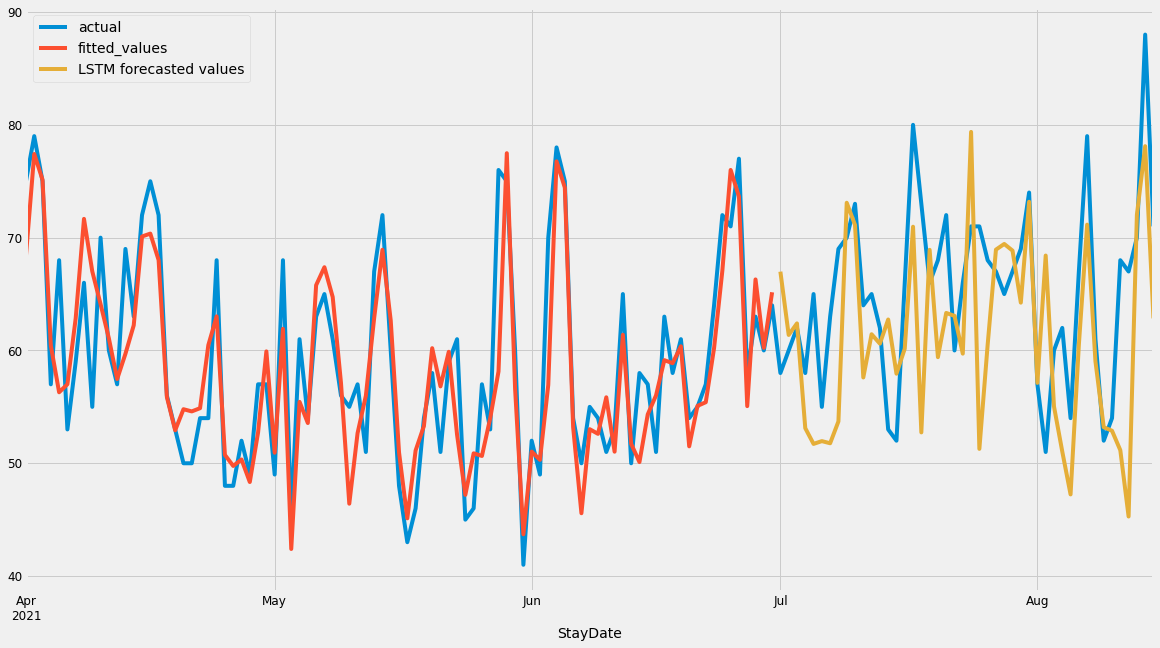

In [36]:
plt.figure(figsize = (18,10))
df.loc['2021-04-01':,'no_of_bookings'].plot(label = 'actual')
fitted_values.loc['2021-04-01':,'lstm_fitted_values'].plot(label = 'fitted_values')
forecasted_values.loc[:,'lstm_values'].plot(label = 'LSTM forecasted values')
plt.legend()
plt.show()

In [37]:
print('lstm Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['lstm_values']))))

lstm Mape : 10.71


# RNN

In [38]:
from tensorflow import keras
from keras import layers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import SimpleRNN
from tensorflow.keras.layers import LSTM, Bidirectional

In [39]:
rnn = keras.Sequential()
rnn.add(LSTM(50,input_shape=(34,1)))
rnn.add(layers.Dense(25))
rnn.add(layers.Dense(25))
rnn.add(layers.Dense(10))
rnn.add(layers.Dense(5))
rnn.add(layers.Dense(1))
rnn.compile(loss='mean_squared_error',optimizer='adam')

In [40]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 12,646
Trainable params: 12,646
Non-trainable params: 0
__________________________________________________

In [41]:
rnn.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1500,batch_size=64,verbose=1)

Epoch 1/1500
20/20 [==============================] - 2s 34ms/step - loss: 2815.5061 - val_loss: 3261.0781
Epoch 2/1500
20/20 [==============================] - 0s 16ms/step - loss: 1410.4503 - val_loss: 652.0539
Epoch 3/1500
20/20 [==============================] - 0s 15ms/step - loss: 203.9962 - val_loss: 155.4528
Epoch 4/1500
20/20 [==============================] - 0s 15ms/step - loss: 157.7120 - val_loss: 154.6139
Epoch 5/1500
20/20 [==============================] - 0s 15ms/step - loss: 157.7929 - val_loss: 178.1726
Epoch 6/1500
20/20 [==============================] - 0s 18ms/step - loss: 156.4424 - val_loss: 179.7986
Epoch 7/1500
20/20 [==============================] - 0s 16ms/step - loss: 155.2205 - val_loss: 146.1181
Epoch 8/1500
20/20 [==============================] - 0s 21ms/step - loss: 155.1954 - val_loss: 184.8084
Epoch 9/1500
20/20 [==============================] - 0s 20ms/step - loss: 153.6886 - val_loss: 163.8286
Epoch 10/1500
20/20 [==============================]

20/20 [==============================] - 0s 19ms/step - loss: 74.5661 - val_loss: 55.5824
Epoch 71/1500
20/20 [==============================] - 0s 23ms/step - loss: 73.7266 - val_loss: 56.6680
Epoch 72/1500
20/20 [==============================] - 0s 15ms/step - loss: 72.5194 - val_loss: 63.4953
Epoch 73/1500
20/20 [==============================] - 0s 21ms/step - loss: 70.9476 - val_loss: 57.4180
Epoch 74/1500
20/20 [==============================] - 0s 17ms/step - loss: 71.6773 - val_loss: 52.7243
Epoch 75/1500
20/20 [==============================] - 0s 17ms/step - loss: 72.2605 - val_loss: 54.6065
Epoch 76/1500
20/20 [==============================] - 0s 21ms/step - loss: 75.0448 - val_loss: 57.7958
Epoch 77/1500
20/20 [==============================] - 0s 21ms/step - loss: 72.4186 - val_loss: 54.3424
Epoch 78/1500
20/20 [==============================] - 0s 15ms/step - loss: 71.0571 - val_loss: 52.1226
Epoch 79/1500
20/20 [==============================] - 0s 19ms/step - loss: 70

20/20 [==============================] - 0s 15ms/step - loss: 65.6082 - val_loss: 54.0457
Epoch 149/1500
20/20 [==============================] - 0s 15ms/step - loss: 64.6745 - val_loss: 54.2340
Epoch 150/1500
20/20 [==============================] - 0s 15ms/step - loss: 64.2403 - val_loss: 54.5656
Epoch 151/1500
20/20 [==============================] - 0s 17ms/step - loss: 65.4163 - val_loss: 56.0232
Epoch 152/1500
20/20 [==============================] - 0s 17ms/step - loss: 65.8435 - val_loss: 53.1264
Epoch 153/1500
20/20 [==============================] - 0s 17ms/step - loss: 64.0246 - val_loss: 52.6787
Epoch 154/1500
20/20 [==============================] - 0s 16ms/step - loss: 67.4853 - val_loss: 53.0041
Epoch 155/1500
20/20 [==============================] - 0s 18ms/step - loss: 64.1508 - val_loss: 52.2306
Epoch 156/1500
20/20 [==============================] - 0s 15ms/step - loss: 63.8347 - val_loss: 52.5781
Epoch 157/1500
20/20 [==============================] - 0s 16ms/step -

20/20 [==============================] - 0s 15ms/step - loss: 60.3829 - val_loss: 55.8783
Epoch 227/1500
20/20 [==============================] - 0s 14ms/step - loss: 58.8588 - val_loss: 48.3296
Epoch 228/1500
20/20 [==============================] - 0s 15ms/step - loss: 61.6607 - val_loss: 53.3083
Epoch 229/1500
20/20 [==============================] - 0s 15ms/step - loss: 63.8229 - val_loss: 43.1680
Epoch 230/1500
20/20 [==============================] - 0s 15ms/step - loss: 60.2534 - val_loss: 52.7079
Epoch 231/1500
20/20 [==============================] - 0s 15ms/step - loss: 62.2887 - val_loss: 51.1220
Epoch 232/1500
20/20 [==============================] - 0s 15ms/step - loss: 60.4746 - val_loss: 50.1257
Epoch 233/1500
20/20 [==============================] - 0s 15ms/step - loss: 63.1706 - val_loss: 44.4033
Epoch 234/1500
20/20 [==============================] - 0s 15ms/step - loss: 62.8691 - val_loss: 51.2337
Epoch 235/1500
20/20 [==============================] - 0s 15ms/step -

20/20 [==============================] - 0s 15ms/step - loss: 55.8114 - val_loss: 64.8078
Epoch 305/1500
20/20 [==============================] - 0s 15ms/step - loss: 55.8813 - val_loss: 63.1731
Epoch 306/1500
20/20 [==============================] - 0s 15ms/step - loss: 54.1179 - val_loss: 44.4071
Epoch 307/1500
20/20 [==============================] - 0s 16ms/step - loss: 55.1029 - val_loss: 53.0699
Epoch 308/1500
20/20 [==============================] - 0s 15ms/step - loss: 58.8805 - val_loss: 50.6601
Epoch 309/1500
20/20 [==============================] - 0s 15ms/step - loss: 59.2506 - val_loss: 45.7498
Epoch 310/1500
20/20 [==============================] - 0s 15ms/step - loss: 54.6530 - val_loss: 50.6833
Epoch 311/1500
20/20 [==============================] - 0s 15ms/step - loss: 55.9070 - val_loss: 56.7435
Epoch 312/1500
20/20 [==============================] - 0s 15ms/step - loss: 61.1576 - val_loss: 48.2459
Epoch 313/1500
20/20 [==============================] - 0s 15ms/step -

20/20 [==============================] - 0s 15ms/step - loss: 51.8321 - val_loss: 64.6906
Epoch 383/1500
20/20 [==============================] - 0s 15ms/step - loss: 53.9803 - val_loss: 54.9830
Epoch 384/1500
20/20 [==============================] - 0s 15ms/step - loss: 52.8213 - val_loss: 51.4692
Epoch 385/1500
20/20 [==============================] - 0s 15ms/step - loss: 51.0317 - val_loss: 52.3221
Epoch 386/1500
20/20 [==============================] - 0s 15ms/step - loss: 50.5307 - val_loss: 62.4303
Epoch 387/1500
20/20 [==============================] - 0s 15ms/step - loss: 52.7073 - val_loss: 63.9650
Epoch 388/1500
20/20 [==============================] - 0s 15ms/step - loss: 51.1995 - val_loss: 65.3389
Epoch 389/1500
20/20 [==============================] - 0s 14ms/step - loss: 51.3998 - val_loss: 69.7421
Epoch 390/1500
20/20 [==============================] - 0s 15ms/step - loss: 53.7656 - val_loss: 55.2999
Epoch 391/1500
20/20 [==============================] - 0s 15ms/step -

Epoch 460/1500
20/20 [==============================] - 0s 15ms/step - loss: 47.6629 - val_loss: 81.3006
Epoch 461/1500
20/20 [==============================] - 0s 15ms/step - loss: 49.9847 - val_loss: 95.5022
Epoch 462/1500
20/20 [==============================] - 0s 15ms/step - loss: 50.6523 - val_loss: 78.8562
Epoch 463/1500
20/20 [==============================] - 0s 15ms/step - loss: 51.6557 - val_loss: 67.9718
Epoch 464/1500
20/20 [==============================] - 0s 15ms/step - loss: 49.0784 - val_loss: 72.3725
Epoch 465/1500
20/20 [==============================] - 0s 15ms/step - loss: 47.6636 - val_loss: 61.2181
Epoch 466/1500
20/20 [==============================] - 0s 15ms/step - loss: 48.0884 - val_loss: 63.5618
Epoch 467/1500
20/20 [==============================] - 0s 15ms/step - loss: 50.7009 - val_loss: 121.7831
Epoch 468/1500
20/20 [==============================] - 0s 15ms/step - loss: 51.7009 - val_loss: 80.8953
Epoch 469/1500
20/20 [==============================] 

Epoch 538/1500
20/20 [==============================] - 0s 15ms/step - loss: 46.9158 - val_loss: 67.3259
Epoch 539/1500
20/20 [==============================] - 0s 15ms/step - loss: 49.6901 - val_loss: 80.1120
Epoch 540/1500
20/20 [==============================] - 0s 15ms/step - loss: 45.9552 - val_loss: 117.0832
Epoch 541/1500
20/20 [==============================] - 0s 15ms/step - loss: 48.8866 - val_loss: 106.4931
Epoch 542/1500
20/20 [==============================] - 0s 15ms/step - loss: 48.7020 - val_loss: 99.1745
Epoch 543/1500
20/20 [==============================] - 0s 14ms/step - loss: 47.3109 - val_loss: 97.0289
Epoch 544/1500
20/20 [==============================] - 0s 15ms/step - loss: 45.9686 - val_loss: 85.9510
Epoch 545/1500
20/20 [==============================] - 0s 15ms/step - loss: 46.2879 - val_loss: 99.3847
Epoch 546/1500
20/20 [==============================] - 0s 15ms/step - loss: 47.3878 - val_loss: 89.7265
Epoch 547/1500
20/20 [==============================]

Epoch 616/1500
20/20 [==============================] - 0s 14ms/step - loss: 44.5124 - val_loss: 88.5285
Epoch 617/1500
20/20 [==============================] - 0s 17ms/step - loss: 44.0943 - val_loss: 118.3389
Epoch 618/1500
20/20 [==============================] - 0s 16ms/step - loss: 44.2390 - val_loss: 105.5873
Epoch 619/1500
20/20 [==============================] - 0s 16ms/step - loss: 45.0425 - val_loss: 108.6101
Epoch 620/1500
20/20 [==============================] - 0s 16ms/step - loss: 43.8342 - val_loss: 128.1734
Epoch 621/1500
20/20 [==============================] - 0s 16ms/step - loss: 44.4024 - val_loss: 96.7957
Epoch 622/1500
20/20 [==============================] - 0s 15ms/step - loss: 44.4262 - val_loss: 86.9281
Epoch 623/1500
20/20 [==============================] - 0s 17ms/step - loss: 45.0149 - val_loss: 94.6029
Epoch 624/1500
20/20 [==============================] - 0s 16ms/step - loss: 45.1888 - val_loss: 98.6317
Epoch 625/1500
20/20 [=============================

20/20 [==============================] - 0s 15ms/step - loss: 42.1937 - val_loss: 105.1920
Epoch 694/1500
20/20 [==============================] - 0s 15ms/step - loss: 44.7919 - val_loss: 92.0286
Epoch 695/1500
20/20 [==============================] - 0s 15ms/step - loss: 43.0865 - val_loss: 99.0445
Epoch 696/1500
20/20 [==============================] - 0s 15ms/step - loss: 41.8303 - val_loss: 113.3349
Epoch 697/1500
20/20 [==============================] - 0s 15ms/step - loss: 41.7207 - val_loss: 105.2510
Epoch 698/1500
20/20 [==============================] - 0s 15ms/step - loss: 42.2952 - val_loss: 97.3824
Epoch 699/1500
20/20 [==============================] - ETA: 0s - loss: 42.83 - 0s 15ms/step - loss: 42.4602 - val_loss: 97.6628
Epoch 700/1500
20/20 [==============================] - 0s 15ms/step - loss: 41.3736 - val_loss: 119.4535
Epoch 701/1500
20/20 [==============================] - 0s 15ms/step - loss: 43.8474 - val_loss: 134.3346
Epoch 702/1500
20/20 [===================

20/20 [==============================] - 0s 15ms/step - loss: 48.9337 - val_loss: 119.5847
Epoch 771/1500
20/20 [==============================] - 0s 15ms/step - loss: 47.5605 - val_loss: 117.9315
Epoch 772/1500
20/20 [==============================] - 0s 15ms/step - loss: 45.7102 - val_loss: 96.9652
Epoch 773/1500
20/20 [==============================] - 0s 15ms/step - loss: 45.6228 - val_loss: 106.5557
Epoch 774/1500
20/20 [==============================] - 0s 15ms/step - loss: 46.9385 - val_loss: 152.0052
Epoch 775/1500
20/20 [==============================] - 0s 16ms/step - loss: 43.8759 - val_loss: 107.9242
Epoch 776/1500
20/20 [==============================] - 0s 16ms/step - loss: 44.1939 - val_loss: 101.8748
Epoch 777/1500
20/20 [==============================] - 0s 15ms/step - loss: 45.9806 - val_loss: 78.7732
Epoch 778/1500
20/20 [==============================] - 0s 15ms/step - loss: 43.4459 - val_loss: 179.3249
Epoch 779/1500
20/20 [==============================] - 0s 15ms

20/20 [==============================] - 0s 15ms/step - loss: 37.7639 - val_loss: 112.2323
Epoch 848/1500
20/20 [==============================] - 0s 15ms/step - loss: 38.4445 - val_loss: 99.6700
Epoch 849/1500
20/20 [==============================] - 0s 15ms/step - loss: 40.8537 - val_loss: 117.4254
Epoch 850/1500
20/20 [==============================] - 0s 15ms/step - loss: 38.2724 - val_loss: 99.4266
Epoch 851/1500
20/20 [==============================] - 0s 15ms/step - loss: 38.1997 - val_loss: 133.2726
Epoch 852/1500
20/20 [==============================] - 0s 15ms/step - loss: 37.9006 - val_loss: 173.5428
Epoch 853/1500
20/20 [==============================] - 0s 15ms/step - loss: 39.5456 - val_loss: 151.5935
Epoch 854/1500
20/20 [==============================] - 0s 15ms/step - loss: 37.6285 - val_loss: 126.9506
Epoch 855/1500
20/20 [==============================] - 0s 15ms/step - loss: 39.8279 - val_loss: 113.2082
Epoch 856/1500
20/20 [==============================] - 0s 15ms

20/20 [==============================] - 0s 15ms/step - loss: 34.7129 - val_loss: 127.4285
Epoch 925/1500
20/20 [==============================] - 0s 15ms/step - loss: 35.1117 - val_loss: 129.6547
Epoch 926/1500
20/20 [==============================] - 0s 15ms/step - loss: 34.4483 - val_loss: 104.9807
Epoch 927/1500
20/20 [==============================] - 0s 15ms/step - loss: 37.9071 - val_loss: 99.8860
Epoch 928/1500
20/20 [==============================] - 0s 15ms/step - loss: 35.8294 - val_loss: 100.8582
Epoch 929/1500
20/20 [==============================] - 0s 15ms/step - loss: 35.1684 - val_loss: 116.0395
Epoch 930/1500
20/20 [==============================] - 0s 14ms/step - loss: 34.6074 - val_loss: 130.3622
Epoch 931/1500
20/20 [==============================] - 0s 15ms/step - loss: 35.4672 - val_loss: 120.0131
Epoch 932/1500
20/20 [==============================] - 0s 15ms/step - loss: 37.2527 - val_loss: 116.3768
Epoch 933/1500
20/20 [==============================] - 0s 16m

20/20 [==============================] - 0s 15ms/step - loss: 34.1129 - val_loss: 107.4327
Epoch 1002/1500
20/20 [==============================] - 0s 15ms/step - loss: 33.1666 - val_loss: 115.3776
Epoch 1003/1500
20/20 [==============================] - 0s 16ms/step - loss: 34.4110 - val_loss: 89.7779
Epoch 1004/1500
20/20 [==============================] - 0s 16ms/step - loss: 33.8077 - val_loss: 130.1151
Epoch 1005/1500
20/20 [==============================] - 0s 15ms/step - loss: 33.2894 - val_loss: 127.8889
Epoch 1006/1500
20/20 [==============================] - 0s 15ms/step - loss: 34.9993 - val_loss: 184.9305
Epoch 1007/1500
20/20 [==============================] - 0s 15ms/step - loss: 35.0696 - val_loss: 158.6273
Epoch 1008/1500
20/20 [==============================] - 0s 15ms/step - loss: 34.3773 - val_loss: 148.9657
Epoch 1009/1500
20/20 [==============================] - 0s 16ms/step - loss: 37.0910 - val_loss: 124.0768
Epoch 1010/1500
20/20 [==============================]

Epoch 1078/1500
20/20 [==============================] - 0s 15ms/step - loss: 29.8834 - val_loss: 145.0363
Epoch 1079/1500
20/20 [==============================] - 0s 15ms/step - loss: 30.0841 - val_loss: 132.3159
Epoch 1080/1500
20/20 [==============================] - 0s 15ms/step - loss: 30.1658 - val_loss: 145.1070
Epoch 1081/1500
20/20 [==============================] - 0s 16ms/step - loss: 31.8614 - val_loss: 143.2045
Epoch 1082/1500
20/20 [==============================] - 0s 15ms/step - loss: 31.7310 - val_loss: 128.8441
Epoch 1083/1500
20/20 [==============================] - 0s 15ms/step - loss: 31.1556 - val_loss: 118.1479
Epoch 1084/1500
20/20 [==============================] - 0s 15ms/step - loss: 31.4266 - val_loss: 119.5869
Epoch 1085/1500
20/20 [==============================] - 0s 15ms/step - loss: 32.4908 - val_loss: 141.2107
Epoch 1086/1500
20/20 [==============================] - 0s 15ms/step - loss: 31.3522 - val_loss: 124.3932
Epoch 1087/1500
20/20 [==============

20/20 [==============================] - 0s 15ms/step - loss: 29.4218 - val_loss: 137.6463
Epoch 1155/1500
20/20 [==============================] - 0s 15ms/step - loss: 29.4174 - val_loss: 145.8401
Epoch 1156/1500
20/20 [==============================] - 0s 15ms/step - loss: 28.3016 - val_loss: 138.7358
Epoch 1157/1500
20/20 [==============================] - 0s 15ms/step - loss: 27.3194 - val_loss: 145.6257
Epoch 1158/1500
20/20 [==============================] - 0s 15ms/step - loss: 27.4164 - val_loss: 171.9530
Epoch 1159/1500
20/20 [==============================] - 0s 14ms/step - loss: 28.1897 - val_loss: 136.7791
Epoch 1160/1500
20/20 [==============================] - 0s 15ms/step - loss: 29.4083 - val_loss: 170.7063
Epoch 1161/1500
20/20 [==============================] - 0s 15ms/step - loss: 29.3331 - val_loss: 143.6784
Epoch 1162/1500
20/20 [==============================] - 0s 15ms/step - loss: 31.0488 - val_loss: 141.1573
Epoch 1163/1500
20/20 [==============================

20/20 [==============================] - 0s 15ms/step - loss: 26.7788 - val_loss: 135.0500
Epoch 1231/1500
20/20 [==============================] - 0s 15ms/step - loss: 26.6244 - val_loss: 184.6095
Epoch 1232/1500
20/20 [==============================] - 0s 15ms/step - loss: 27.5919 - val_loss: 129.9900
Epoch 1233/1500
20/20 [==============================] - 0s 15ms/step - loss: 27.3346 - val_loss: 148.1022
Epoch 1234/1500
20/20 [==============================] - 0s 15ms/step - loss: 26.9415 - val_loss: 154.7377
Epoch 1235/1500
20/20 [==============================] - 0s 15ms/step - loss: 27.5906 - val_loss: 185.0874
Epoch 1236/1500
20/20 [==============================] - 0s 15ms/step - loss: 28.3918 - val_loss: 147.0210
Epoch 1237/1500
20/20 [==============================] - 0s 15ms/step - loss: 28.2138 - val_loss: 135.5081
Epoch 1238/1500
20/20 [==============================] - 0s 15ms/step - loss: 28.2721 - val_loss: 178.1590
Epoch 1239/1500
20/20 [==============================

20/20 [==============================] - 0s 15ms/step - loss: 23.8047 - val_loss: 124.2087
Epoch 1307/1500
20/20 [==============================] - 0s 15ms/step - loss: 25.3331 - val_loss: 177.7122
Epoch 1308/1500
20/20 [==============================] - 0s 15ms/step - loss: 27.0918 - val_loss: 152.2710
Epoch 1309/1500
20/20 [==============================] - 0s 15ms/step - loss: 26.3862 - val_loss: 130.1324
Epoch 1310/1500
20/20 [==============================] - 0s 15ms/step - loss: 25.6508 - val_loss: 133.4308
Epoch 1311/1500
20/20 [==============================] - 0s 15ms/step - loss: 24.2029 - val_loss: 162.0644
Epoch 1312/1500
20/20 [==============================] - 0s 15ms/step - loss: 24.2532 - val_loss: 129.4064
Epoch 1313/1500
20/20 [==============================] - 0s 15ms/step - loss: 24.0832 - val_loss: 140.1039
Epoch 1314/1500
20/20 [==============================] - 0s 15ms/step - loss: 25.0023 - val_loss: 141.0609
Epoch 1315/1500
20/20 [==============================

20/20 [==============================] - 0s 15ms/step - loss: 22.1048 - val_loss: 135.3178
Epoch 1383/1500
20/20 [==============================] - 0s 15ms/step - loss: 22.2151 - val_loss: 148.0920
Epoch 1384/1500
20/20 [==============================] - 0s 15ms/step - loss: 21.8113 - val_loss: 139.2688
Epoch 1385/1500
20/20 [==============================] - 0s 15ms/step - loss: 23.6626 - val_loss: 165.7807
Epoch 1386/1500
20/20 [==============================] - 0s 16ms/step - loss: 22.9441 - val_loss: 150.7527
Epoch 1387/1500
20/20 [==============================] - 0s 16ms/step - loss: 23.5415 - val_loss: 132.6233
Epoch 1388/1500
20/20 [==============================] - 0s 15ms/step - loss: 23.0833 - val_loss: 138.2802
Epoch 1389/1500
20/20 [==============================] - 0s 15ms/step - loss: 23.6106 - val_loss: 135.3931
Epoch 1390/1500
20/20 [==============================] - 0s 15ms/step - loss: 23.2578 - val_loss: 153.0112
Epoch 1391/1500
20/20 [==============================

20/20 [==============================] - 0s 14ms/step - loss: 21.0726 - val_loss: 142.0379
Epoch 1459/1500
20/20 [==============================] - 0s 15ms/step - loss: 21.7256 - val_loss: 127.0917
Epoch 1460/1500
20/20 [==============================] - 0s 15ms/step - loss: 21.4463 - val_loss: 125.6386
Epoch 1461/1500
20/20 [==============================] - 0s 15ms/step - loss: 22.0481 - val_loss: 148.2811
Epoch 1462/1500
20/20 [==============================] - 0s 15ms/step - loss: 20.2476 - val_loss: 166.7024
Epoch 1463/1500
20/20 [==============================] - 0s 15ms/step - loss: 22.1623 - val_loss: 155.3643
Epoch 1464/1500
20/20 [==============================] - 0s 15ms/step - loss: 19.8876 - val_loss: 141.3069
Epoch 1465/1500
20/20 [==============================] - 0s 15ms/step - loss: 20.7445 - val_loss: 154.7730
Epoch 1466/1500
20/20 [==============================] - 0s 15ms/step - loss: 19.7747 - val_loss: 128.8147
Epoch 1467/1500
20/20 [==============================

In [42]:
### Lets Do the prediction and check performance metrics
train_predict = rnn.predict(X_train)
test_predict = rnn.predict(X_test)

In [43]:
math.sqrt(mean_squared_error(y_test,test_predict))

10.027457718392744

In [44]:
mean_absolute_percentage_error(y_test,test_predict)

14.59

In [45]:
fitted_values['rnn_fitted_values'] = train_predict
forecasted_values['rnn_values'] = test_predict

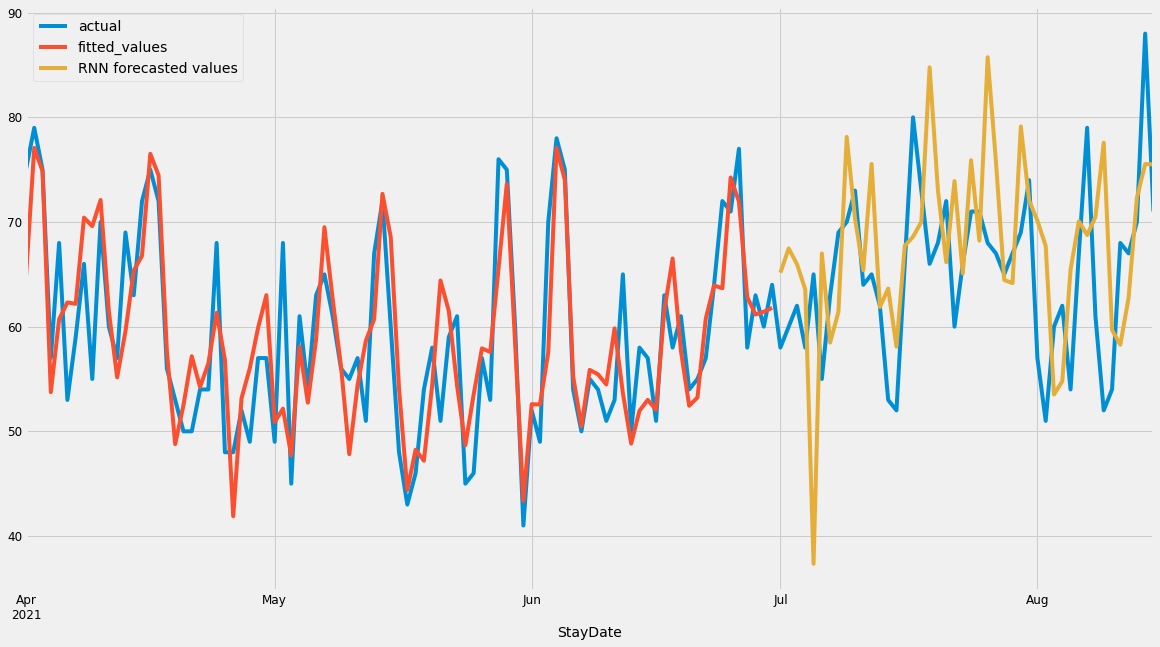

In [46]:
plt.figure(figsize = (18,10))
df.loc['2021-04-01':,'no_of_bookings'].plot(label = 'actual')
fitted_values.loc['2021-04-01':,'rnn_fitted_values'].plot(label = 'fitted_values')
forecasted_values.loc[:,'rnn_values'].plot(label = 'RNN forecasted values')
plt.legend()
plt.show()

# Results

In [47]:
forecasted_values.head(5)

,no_of_bookings,year,week_number,week_day,gb_values,tuned_gb_values,lstm_values,rnn_values
StayDate,,,,,,,,
2021-07-01,58,2021,26,3,63.024407,62.240886,66.986168,65.159248
2021-07-02,60,2021,26,4,64.830766,68.260103,61.375534,67.476723
2021-07-03,62,2021,26,5,67.030852,66.074890,62.399094,65.977753
2021-07-04,58,2021,26,6,58.268629,58.035952,53.113880,63.559601
2021-07-05,65,2021,27,0,52.679977,60.870840,51.716789,37.344120


In [48]:
forecasted_values['lstm_rnn'] = (forecasted_values['rnn_values'] + forecasted_values['lstm_values'])/2
forecasted_values['lstm_tunedgb'] = (forecasted_values['lstm_values'] + forecasted_values['tuned_gb_values'])/2
forecasted_values['tunedgb_rnn'] = (forecasted_values['rnn_values'] + forecasted_values['tuned_gb_values'])/2
forecasted_values['lstm_gb'] = (forecasted_values['lstm_values'] + forecasted_values['gb_values'])/2
forecasted_values['gb_rnn'] = (forecasted_values['rnn_values'] + forecasted_values['gb_values'])/2

results['lstm'] = forecasted_values.loc['2021-07-02':, 'lstm_values'].values
results['rnn'] = forecasted_values.loc['2021-07-02':, 'rnn_values'].values
results['bidir_lstm'] = forecasted_values.loc['2021-07-02':, 'bidir_lstm_values'].values

#results['arima_lstm'] = (results['forecasted_values'] + results['lstm'])/2
#results['arima_rnn'] = (results['forecasted_values'] + results['rnn'])/2
#results['arima_bilstm'] = (results['forecasted_values'] + results['bidir_lstm'])/2

results['lstm_rnn'] = (results['rnn'] + results['lstm'])/2
results['lstm_bilstm'] = (results['rnn'] + results['bidir_lstm'])/2

results['bilstm_rnn'] = (results['rnn'] + results['bidir_lstm'])/2

#results['arima_lstm_rnn'] = (results['forecasted_values'] + results['lstm'] + results['rnn'])/3

#results['combined_results'] = (results['forecasted_values'] + results['lstm'] + results['rnn'] + results['bidir_lstm'] )/4
results['StayDate'] = pd.to_datetime(results['StayDate'])
results.set_index('StayDate', inplace = True)
results.sort_index(inplace=True)

In [49]:

print('lstm Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['lstm_values']))))
print('rnn Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['rnn_values']))))
print('gb Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['gb_values']))))
print('tuned gb Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['tuned_gb_values']))))

print('lstm_rnn Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['lstm_rnn']))))
print('lstm_tunedgb Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['lstm_tunedgb']))))
print('tunedgb_rnn Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['tunedgb_rnn']))))
print('lstm_gb Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['lstm_gb']))))
print('gb_rnn Mape : {}'.format(mean_absolute_percentage_error(np.array(forecasted_values['no_of_bookings']),np.array(forecasted_values['gb_rnn']))))

lstm Mape : 10.71
rnn Mape : 12.77
gb Mape : 8.54
tuned gb Mape : 8.77
lstm_rnn Mape : 9.96
lstm_tunedgb Mape : 8.82
tunedgb_rnn Mape : 9.93
lstm_gb Mape : 8.69
gb_rnn Mape : 9.9


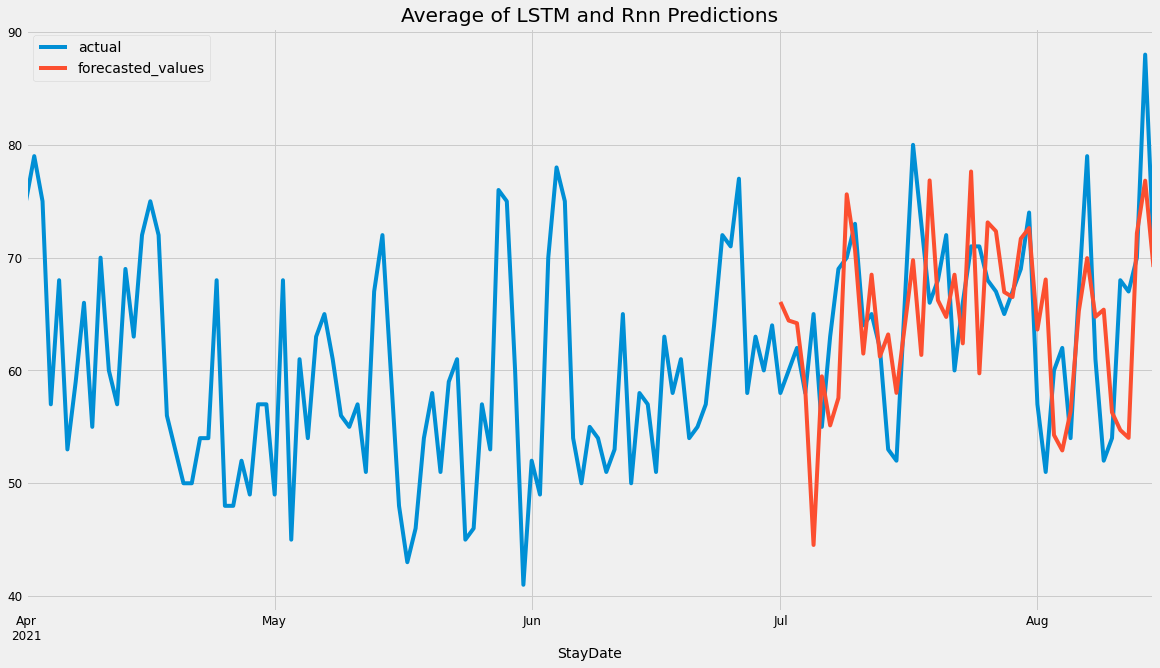

In [50]:
plt.figure(figsize = (18,10))
df.loc['2021-04-01':,'no_of_bookings'].plot(label = 'actual')
#fitted_values.loc['2021-04-01':,'fitted_values'].plot(label = 'fitted_values')
forecasted_values.loc[:,'lstm_rnn'].plot(label = 'forecasted_values')
plt.title('Average of LSTM and Rnn Predictions')
plt.legend()
plt.show()

plt.figure(figsize = (18,10))
df.loc['2021-04-01':,'no_of_bookings'].plot(label = 'actual')
#fitted_values.loc['2021-04-01':,'fitted_values'].plot(label = 'fitted_values')
results.loc[:,'arima_lstm_rnn'].plot(label = 'forecasted_values')
plt.title('Average of ARIMA, LSTM and Rnn Predictions')
plt.legend()
plt.show()

In [51]:
forecasted_values.to_csv('forecasted_values_tuned_RRI133.csv')

In [52]:
end = time.time()
print(end - start)

2699.9776997566223
